<h1>Fundamentals of Probabilistic Data Mining</h1>
<h3>Ensimag - Grenoble INP, AA 2017-2018</h3>
<h2>Lab #2</h2>

In [1]:
import os
import numpy
import matplotlib.pyplot as plt
from sklearn import mixture
from scipy import linalg
import matplotlib as mpl
import itertools
import sys

base_dir = "./Unistroke"
letter = "A"
output_suffix = "merge.txt"

<h4>Preprocessing (PAOLO, NOT NEEDED)</h4>
<p>Here all the files containing the trajectories representing the "A" letter are merged together and saved in a file named "Amerge.txt"<br>It is worth noting that, even though using this approach we lose the temporal relationship between samples, this doesn't affect the analysis we are interested in.</p>

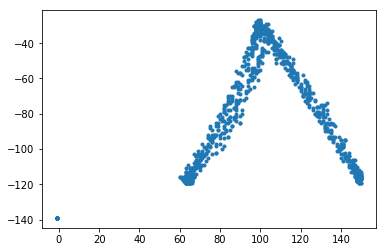

In [2]:
filenames = os.listdir(base_dir)
aFiles = [filename for filename in filenames if letter in filename]

data = numpy.empty([0, 2])
for file in aFiles:
    tmp_data = numpy.loadtxt(base_dir + "/" + file)
    data = numpy.concatenate((data, tmp_data))

#numpy.savetxt(letter + output_suffix, data)

plt.plot(data[::,0], -data[::,1], '.')
plt.savefig("Report/img/AmergePlot.pdf")
plt.show()

<h5>Dataset Normalisation (PAOLO, NOT NEEDED)</h5>

In [3]:
data = (data - numpy.mean(data, axis = 0))/numpy.std(data, axis = 0)

<h5>Dataset Plot (PAOLO, NOT NEEDED)</h5>
<p>Y values in the dataset are reversed, here their sign is inverted to make the graph represents the "A" letter.

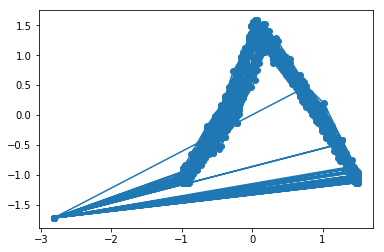

In [4]:
plt.plot(data[::,0], -data[::,1], '-o')
plt.show()

<h3>3.1 Lab Work</h3>
<h4>3.1.1 Modelling</h4>
<p>A priori (before reading the data), do you think a two-state Gaussian model could be appropriate? Why?</p>
<p>A bivariate Gaussian model may be appropriate for modelling the process of drawing a letter "A". In fact, the two variables will be the two dimensions (x,y) upon which our dataset is defined.<br>In addition a two components mixture model it is supposed to perform well in this situation where we can intuitively imagine the "A" letter is represented through two main gestures, which must correspond to two peaks in dataset distribution.</p>

<h4>3.1.2 Data analysis: Gaussian model</h4>

<h5>Dataset Plot</h5>

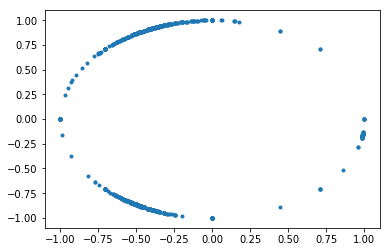

In [5]:
data = numpy.loadtxt("Amerge.txt")
plt.plot(data[::, 0], data[::, 1], '.')
plt.savefig("Report/img/AmergeNPlot.pdf")
plt.show()

<h5>Model Validation (optional)</h5>

<p>Here the gaussian mixture nodel parameters are valided. The best set of parameters is chosen through the "BIC" (Bayesian Information Criterion) metric, which takes into account the likelihood of samples for the given model (see https://en.wikipedia.org/wiki/Bayesian_information_criterion) <br> It turns out the best convariance type for a two components model is "spherical" while the best model overall is the one with "16" components and a "full" covariance matrix. The fact the best model has so many componentes may suggest a Gaussian Mixture model is not appropriate in this case.</p>

In [6]:
lowest_bic = numpy.infty
bic = []
n_components_range = range(2, 8)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(data)
        bic.append(gmm.bic(data))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
            best_nc = n_components
            best_type = cv_type
            if n_components == 2:
                two_components_gmm = gmm
                best_two_components_type = cv_type

print("Best 2 components covariance type: " + best_two_components_type)
print("Best covariance type overall: " + best_type)
print("Best number of components overall: " + str(best_nc))

best_predictions = best_gmm.predict(data)

Best 2 components covariance type: spherical
Best covariance type overall: full
Best number of components overall: 7


<h5>Dataset Labelling</h5>

In [7]:
two_components_predictions = two_components_gmm.predict(data)
best_predictions= best_gmm.predict(data)

<h5>Graphical Validation Method</h5>

In [8]:
plot_number = 0;
def plot_results(gmm, data, index, title):
    global plot_number;
    plot_number += 1;
    color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold', 'darkorange'])
    means = gmm.means_
    covariances = gmm.covariances_
    predictions = gmm.predict(data)
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        if(gmm.covariance_type == "spherical"):
            covar = numpy.eye(means.shape[1]) * covar
        v, w = linalg.eigh(covar)
        v = 2. * numpy.sqrt(2.) * numpy.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not numpy.any(predictions == i):
            continue
        plt.scatter(data[predictions == i, 0], data[predictions == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = numpy.arctan(u[1] / u[0])
        angle = 180. * angle / numpy.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    padding = 0.25
    plt.xlim(numpy.min(data[::, 0]) - padding, numpy.max(data[::, 0]) + padding)
    plt.ylim(numpy.min(data[::, 1]) - padding * 3, numpy.max(data[::, 1]) + padding * 3)
    plt.title(title)
    #plt.savefig("Report/img/gvalidation" + str(plot_number) + ".pdf")
    plt.figure(figsize=(2, 5))
    plt.show()

<h5>2 components GMM plot</h5>

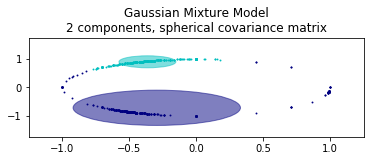

In [9]:
plot_results(two_components_gmm, data, 0, 
             "Gaussian Mixture Model\n2 components, " + str(best_two_components_type) + " covariance matrix")

<h5>Best GMM Plot</h5>

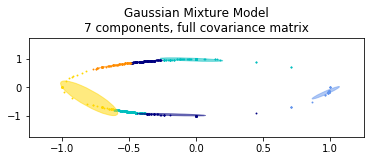

In [10]:
plot_results(best_gmm, data, 0,
             "Gaussian Mixture Model\n" + str(best_nc) + " components, " + str(best_type) + " covariance matrix")

<h5>Question 3.2.1</h5>
<p>Extend the scikit-learn mixture library by implementing mixtures of von Mises distributions. Justify the E-step of the EM algorithm with equations. </p>

<p>To implement the Von Mises distribution we used a module developed using sklearn called <b>spherecluster</b> developed to be used for spherical clustering and it allows us to use Mixture of von Mises Fisher distributions.</p>

<p>Much like the Gaussian distribution is parameterized by mean and variance, the von Mises Fisher distribution has a mean direction $\mu$ and a concentration parameter $\kappa$. Each point $x_i$ drawn from the vMF distribution lives on the surface of the unit hypersphere $\S^{N-1}$ (i.e., $\|x_i\|_2 = 1$) as does the mean direction $\|\mu\|_2 = 1$. Larger $\kappa$ leads to a more concentrated cluster of points.
</p>
<p>
If we model our data as a mixture of von Mises Fisher distributions, we have an additional weight parameter $\alpha$ for each distribution in the mixture. The movMF algorithms estimate the mixture parameters via expectation-maximization (EM) enabling us to cluster data accordingly.
</p>

<p>
In this case the soft-assignment is chosen for the clustering. Label assigment is achieved by computing the argmax of the posterior for each example.</p>


In [11]:
from spherecluster import VonMisesFisherMixture

vmf_soft = VonMisesFisherMixture(n_clusters=2, posterior_type='soft')
vmf_soft.fit(data)
'''
print (data)
print (vmf_soft.cluster_centers_)
print (vmf_soft.labels_)
print (vmf_soft.weights_)
print (vmf_soft.concentrations_)
print (vmf_soft.inertia_)
'''

'\nprint (data)\nprint (vmf_soft.cluster_centers_)\nprint (vmf_soft.labels_)\nprint (vmf_soft.weights_)\nprint (vmf_soft.concentrations_)\nprint (vmf_soft.inertia_)\n'

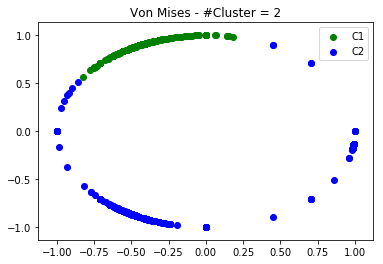

In [12]:
from matplotlib import pylab
import pylab as pl

colors = ['b', 'g', 'r']

for i in range(0, data.shape[0]):
    if vmf_soft.labels_[i] == 1:
        c1 = pl.scatter(data[i,0],data[i,1],c=colors[int(vmf_soft.labels_[i])],marker='o')
    elif vmf_soft.labels_[i] == 0:
        c2 = pl.scatter(data[i,0],data[i,1],c=colors[int(vmf_soft.labels_[i])], marker='o')

pl.legend([c1, c2],['C1', 'C2'])
pl.title('Von Mises - #Cluster = 2')
plt.savefig("Report/img/vonmises_k2.pdf")
pl.show()

In [13]:
''' NOT NEEDED
vmf_soft = VonMisesFisherMixture(n_clusters=3, posterior_type='soft')
vmf_soft.fit(data)

for i in range(0, data.shape[0]):
    if vmf_soft.labels_[i] == 1:
        c1 = pl.scatter(data[i,0],data[i,1],c=colors[int(vmf_soft.labels_[i])],marker='o')
    elif vmf_soft.labels_[i] == 0:
        c2 = pl.scatter(data[i,0],data[i,1],c=colors[int(vmf_soft.labels_[i])], marker='o')
    elif vmf_soft.labels_[i] == 2:
        c3 = pl.scatter(data[i,0],data[i,1],c=colors[int(vmf_soft.labels_[i])], marker='o')

pl.legend([c1, c2, c3],['C1', 'C2', 'C3'])
pl.title('Von Mises - #Cluster = 3')
plt.savefig("Report/img/vonmises_k3.pdf")
pl.show()
'''

' NOT NEEDED\nvmf_soft = VonMisesFisherMixture(n_clusters=3, posterior_type=\'soft\')\nvmf_soft.fit(data)\n\nfor i in range(0, data.shape[0]):\n    if vmf_soft.labels_[i] == 1:\n        c1 = pl.scatter(data[i,0],data[i,1],c=colors[int(vmf_soft.labels_[i])],marker=\'o\')\n    elif vmf_soft.labels_[i] == 0:\n        c2 = pl.scatter(data[i,0],data[i,1],c=colors[int(vmf_soft.labels_[i])], marker=\'o\')\n    elif vmf_soft.labels_[i] == 2:\n        c3 = pl.scatter(data[i,0],data[i,1],c=colors[int(vmf_soft.labels_[i])], marker=\'o\')\n\npl.legend([c1, c2, c3],[\'C1\', \'C2\', \'C3\'])\npl.title(\'Von Mises - #Cluster = 3\')\nplt.savefig("Report/img/vonmises_k3.pdf")\npl.show()\n'

<h5>Question 3.2.2</h5>
<p>What is a consistent estimator of mixture parameters? Imagine, describe and implement a protocol to evaluate consistency of any arbitrary estimator. Test this protocol on the algorithm developed in the previous question. </p>

<p>The algorithm reported into the report is evaluated, in this case the function take 10, 20 ... 100% of the data and evaluate the inertia to verify that it decreases.</p>

In [14]:
mu, kappa = 0, 1.0
data_ev = []
for x in range(0, 200):
    s = numpy.random.vonmises(mu, kappa, 2)
    data_ev.append(s)
    
mu, kappa = 3.0, 1.5
for x in range(0, 200):
    s = numpy.random.vonmises(mu, kappa, 2)
    data_ev.append(s)

from random import shuffle
shuffle(data_ev)

print (data_ev)

[array([-1.81424191,  0.23538957]), array([-1.46886039,  2.40884365]), array([1.53891953, 2.87326044]), array([ 1.94456932, -2.79862459]), array([0.62452558, 0.12400461]), array([ 2.99252734, -1.93416813]), array([-2.03164226, -1.11170086]), array([ 0.23878501, -0.1881461 ]), array([-1.08050398,  2.44583445]), array([-0.55457603, -0.28646882]), array([2.03500044, 2.9333255 ]), array([-0.24029707,  0.22500699]), array([1.62811297, 2.82628427]), array([0.17909525, 1.70740259]), array([-0.98187661,  1.2565585 ]), array([-2.98703566,  2.32585225]), array([-2.99263333, -2.99431158]), array([-0.84714294, -0.62640866]), array([2.81393403, 2.90599346]), array([-0.51501287,  3.01286616]), array([ 3.06039151, -2.81215856]), array([ 2.21657576, -2.25019185]), array([ 0.70732558, -0.39790688]), array([0.84056429, 0.01057145]), array([ 1.38908163, -0.79183759]), array([1.26496745, 1.55092749]), array([0.29951984, 3.11586368]), array([0.6884019, 0.0914355]), array([-1.46621322e-03, -2.15051545e+00])

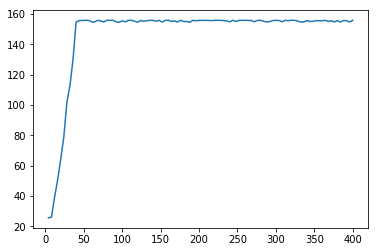

In [16]:
def evaluate_consistency(data):
    size = len(data)
    inertias = []
    data_sizes = []
    for i in range(1, 101, 1):
        newData = data[:int(i/10*size)]
        vmf_soft = VonMisesFisherMixture(n_clusters=2, posterior_type='soft')
        vmf_soft.fit(newData)
        inertias.append(vmf_soft.inertia_)
        data_sizes.append(int(i/100*size))

    return (inertias, data_sizes)

inertias, data_sizes = evaluate_consistency(data_ev)
plt.plot(data_sizes, inertias, '')
plt.savefig("Report/img/convergence_inertia_vm.pdf")
plt.show()